In [1]:
!pip install tensorflow

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
from math import ceil
import seaborn as sns
from scipy import stats

In [3]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [4]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Patient Real Heart Rate')
    plt.plot(predicted, color='blue',label='Patient Predicted Heart Rate')
    plt.title('Heart Rate Prediction')
    plt.xlabel('Time')
    plt.ylabel('mV')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    mae =mean_absolute_error(test, predicted)
    print(f"The mean absolute error is {mae}.")

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [6]:
def create_time_steps(length):
    return list(range(-length, 0))

In [7]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History',kind='line')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future',kind='line')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro')
    plt.legend(loc='upper left')
    plt.show()

In [8]:
tf.random.set_seed(13)

In [9]:
df = pd.read_csv('../../data/raw/parabola_100K.csv', index_col='x')
df.head()

,fx
x,
-50000,2500000000
-49999,2499900001
-49998,2499800004
-49997,2499700009
-49996,2499600016


In [10]:
int(df.shape[0] * 0.5)

50000

In [11]:
df.tail(5)

,fx
x,
49996,2499600016
49997,2499700009
49998,2499800004
49999,2499900001
50000,2500000000


## Training for 60% of the base

In [12]:
train = df.iloc[0:int(df.shape[0]*0.5)].values

In [13]:
test = df.iloc[int(df.shape[0]*0.5):].values

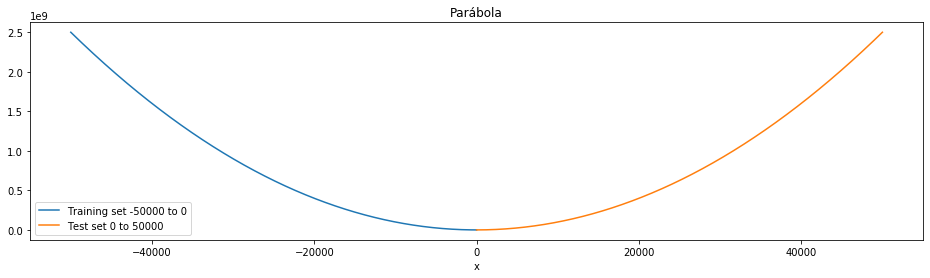

In [14]:
df["fx"].iloc[0:int(df.shape[0]*0.5)].plot(figsize=(16,4),legend=True)
df["fx"].iloc[int(df.shape[0]*0.5):].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set -50000 to 0',f'Test set 0 to 50000'])
plt.title('Parábola')
plt.show()

In [15]:
uni_data = df['fx']
uni_data.head()

x
-50000    2500000000
-49999    2499900001
-49998    2499800004
-49997    2499700009
-49996    2499600016
Name: fx, dtype: int64

In [16]:
uni_data = uni_data.values

In [17]:
uni_train_mean = uni_data[:int(df.shape[0]*0.5)].mean()
uni_train_std = uni_data[:int(df.shape[0]*0.5)].std()

In [18]:
uni_train_mean

833358333.5

In [19]:
uni_train_std

745369967.7471827

Let's standardize the data.

In [20]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [21]:
univariate_past_history = 900
univariate_future_target = 100

x_train_uni, y_train_uni = univariate_data(uni_data, 0, int(df.shape[0]*0.7),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, int(df.shape[0]*0.3), None,
                                       univariate_past_history,
                                       univariate_future_target)

# Model testing

In [22]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='swish'))
multi_step_model.add(tf.keras.layers.Dense(1))

tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [23]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_multi = train_data_multi.cache().shuffle(300).batch(900).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_multi = val_data_multi.batch(900).repeat()

In [24]:
train_data_multi

<RepeatDataset shapes: ((None, 900, 1), (None,)), types: (tf.float64, tf.float64)>

Batch de 100 com shuffle de 50 não roda bem

In [25]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=5,
                                          steps_per_epoch=20,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/5
 2/20 [==>...........................] - ETA: 16s - loss: 1.9856

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-d21efc5d2963>", line 4, in <module>
    validation_steps=50)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 1098, in fit
    tmp_logs = train_function(iterator)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py", line 780, in __call__
    result = self._call(*args, **kwds)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py", line 807, in _call
    return sel

KeyboardInterrupt: 

#### Swish
- a função possui um loss bem proximo de seu validation durante todo o treinamento.
- elas começam a convergir mais para o final.
- na ultima época temos um loss e um validation loss bem próximos, na casa dos 10%
- Com Swish temos um ganho na distância das ondas, aqui a distância é de 2.

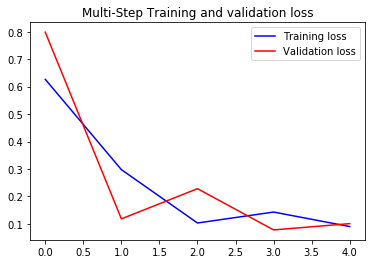

In [34]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.7368692996713779, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.741462553344384, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=1.0, pvalue=0.0)


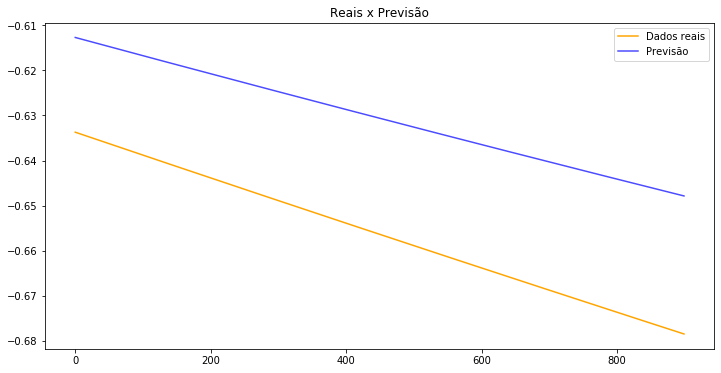

In [36]:
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

#### SoftPlus
- Começou com um loss bem baixo, 35%, porém o loss de validation é de 100%, overfitting?
- Conseguimos um validation loss melhor na segunda época, 13% invalidou o overfitting, o early stop ficará com o melhor resultado.
- A partir da 4 época já temos um loss muito grande
- validation loss final por conta do early stop foi de 0.18, vamos ver resultados!

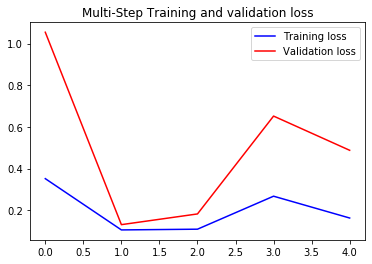

In [28]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.7368692996713779, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.7301768125951706, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=1.0, pvalue=0.0)


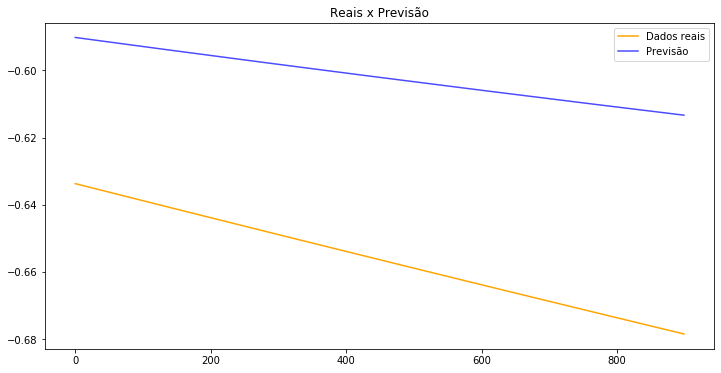

In [48]:
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

#### Elu
- elu está indo bem, na 3 epoca conseguimos loss de 8%
- na 3 epoca ele começa a perder loss, será que existe uma função de early stop com tensor flow?
- loss de 20%, relativamente alto.
- Mesmo com ativação Elu temos uma distância grande desviando 0.04.

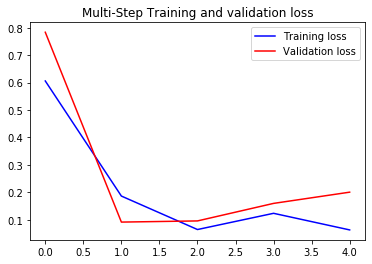

In [46]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.7368692996713779, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.7377464162135385, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=1.0, pvalue=0.0)


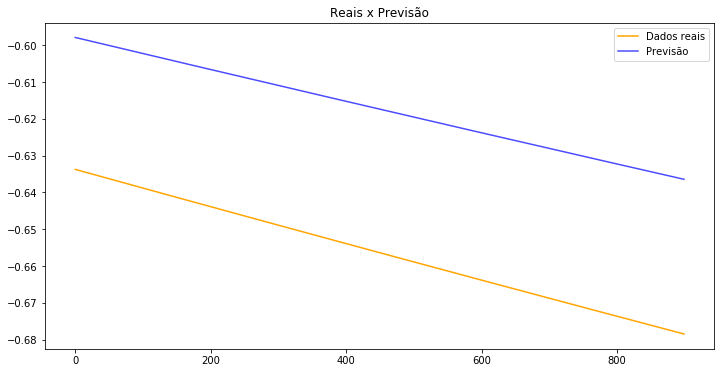

#### Relu
- relu está indo bem, na 3 epoca conseguimos loss de 10%
- na 4 epoca ele começa a perder loss, Vou tentar aplicar um keras early stop! :)
- Na 4 epoca ele perde loss porém ganha no teste.
- Na 5 epoca o loss é melhor apenas 6%
- A Distância diminuiu desta vez, agora é de 0.03

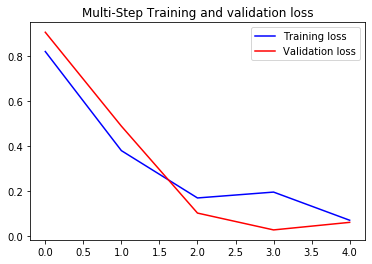

In [39]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.7368692996713779, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.7377464162135385, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=1.0, pvalue=0.0)


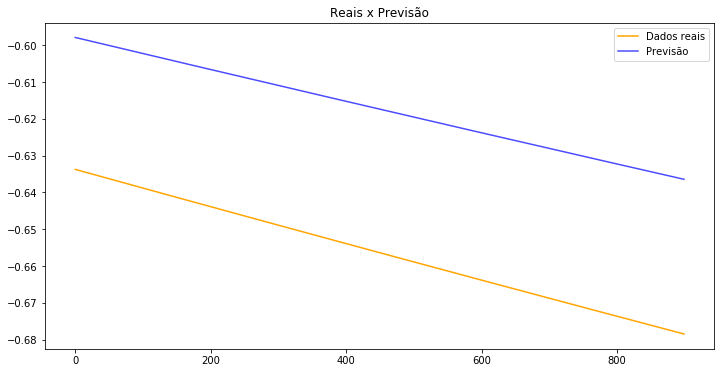

In [38]:
df.head(4)

,fx
x,
-50000,2500000000
-49999,2499900001
-49998,2499800004
-49997,2499700009


## Utilizar um batch menor, otimiza a época

## Alcançamos um resultado bom com 5 épocas, utilizando 30 passos.
## É necessário otimizar melhor o modelo, 10 épocas está se provando ser muito lento o que gera muito gasto

## Multi-Step Training

## Olhar se estou subtraindo por uma constante.

# Tentando otimizar o Swish

In [49]:
univariate_past_history = 900
univariate_future_target = 100

x_train_uni, y_train_uni = univariate_data(uni_data, 0, int(df.shape[0]*0.7),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, int(df.shape[0]*0.3), None,
                                       univariate_past_history,
                                       univariate_future_target)

# Model testing

In [50]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='swish'))
multi_step_model.add(tf.keras.layers.Dense(1))

tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [51]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_multi = train_data_multi.cache().shuffle(50).batch(450).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_multi = val_data_multi.batch(450).repeat()

In [52]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=5,
                                          steps_per_epoch=20,
                                          validation_data=val_data_multi,
                                          validation_steps=20)

Epoch 1/5
20/20 [==============================] - 27s 1s/step - loss: 3.1146 - val_loss: 0.7528
Epoch 2/5
20/20 [==============================] - 26s 1s/step - loss: 0.0393 - val_loss: 0.7474
Epoch 3/5
20/20 [==============================] - 26s 1s/step - loss: 0.1781 - val_loss: 0.5586
Epoch 4/5
20/20 [==============================] - 26s 1s/step - loss: 0.1473 - val_loss: 0.0375
Epoch 5/5
20/20 [==============================] - 26s 1s/step - loss: 0.1020 - val_loss: 0.1091


- Batch 300 + shuffle 20 = Overfitting, usando 20 passos por epoca
- Batch 300 + shuffle 50 = Overfitting, usando 20 passos por epoca

- Batch 450 + shuffle 50 = Perfeito, 10% de loss e 10% de val_loss.
- Problema é que sua distância fica maior

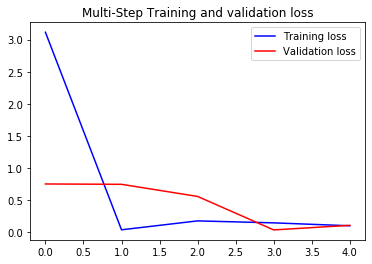

In [53]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.7368692996713779, pvalue=5.2875756515243195e-251)
result for ks on prediction is KstestResult(statistic=0.7184407157578996, pvalue=7.241292823844698e-236)
Results for spearman correlation is SpearmanrResult(correlation=1.0, pvalue=0.0)


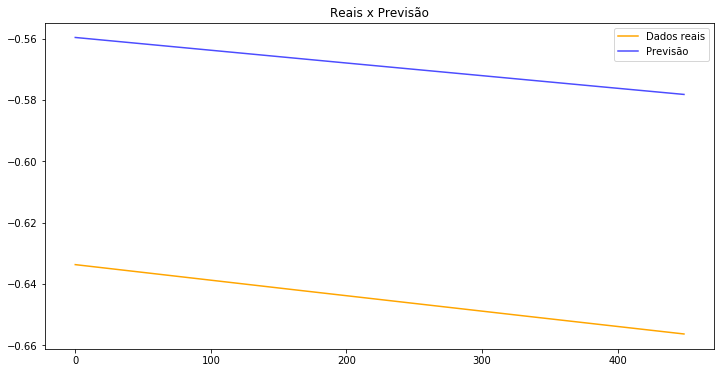

In [54]:
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

## Plottar O gráfico de -1000 a 1000
## Manter batchs maiores, próximos do nosso passado de treinamento

### Fazer um com tanh 
- testar com outros